In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d 
import torch 
from torch.utils.data import Dataset, DataLoader 
import torch.nn as nn
torch.manual_seed(1)

In [4]:
# Some Data 
class Data(Dataset): 
    def __init__(self): 
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1) 
        self.y = torch.zeros(self.x.shape[0], 1) 
        self.y[self.x[:, 0] > 0.2] = 1
        self.len = self.x.shape[0] 
    
    def __getitem__(self, index): 
        return self.x[index], self.y[index] 

    def __len__(self):
        return self.len
data_set = Data()

In [6]:
class LogisticRegression(nn.Module): 
    def __init__(self, n_inputs):
        super(LogisticRegression, self).__init__() 
        self.linear = nn.Linear(n_inputs, 1) 
    
    def forward(self, x): 
        y_hat = torch.sigmoid(self.linear(x))
        return y_hat

In [7]:
model = LogisticRegression(1) 

# Replace randomly initialized weights and bias with predetermined values that will not converge 
model.state_dict()['linear.weight'].data[0] = torch.tensor([[-5]]) 
model.state_dict()['linear.bias'].data[0] = torch.tensor([[-10]]) 
model.state_dict()

OrderedDict([('linear.weight', tensor([[-5.]])),
             ('linear.bias', tensor([-10.]))])

In [8]:
# Create class for plotting and the function for plotting

class plot_error_surfaces(object):
    
    # Construstor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - (1 / (1 + np.exp(-1*w2 * self.x - b2)))) ** 2)
                count2 += 1   
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.plot(self.x, 1 / (1 + np.exp(-1 * (self.W[-1] * self.x + self.B[-1]))), label='sigmoid')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        
# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg=True):
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass

<Figure size 640x480 with 0 Axes>

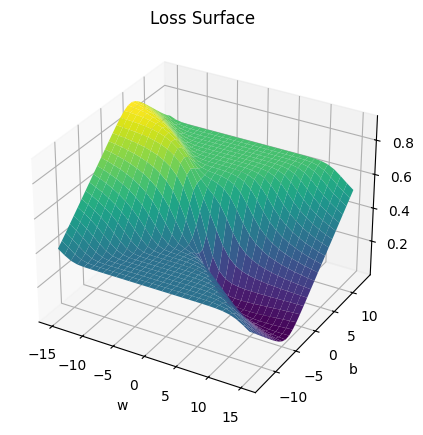

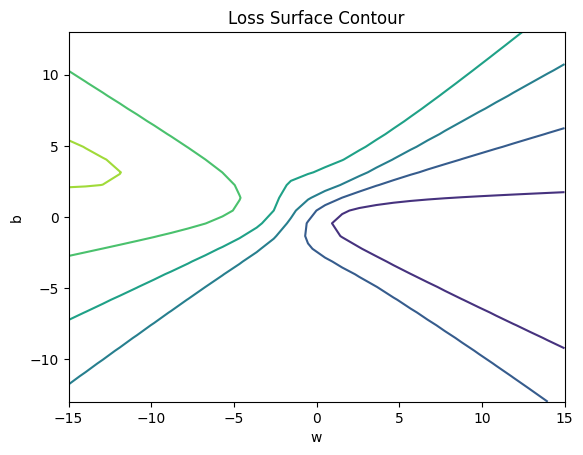

In [9]:
# Create the plot_error_surfaces object

get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

In [11]:
train_loader = DataLoader(dataset=data_set, batch_size=3) 
criterion = nn.MSELoss() 
learning_rate = 2 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

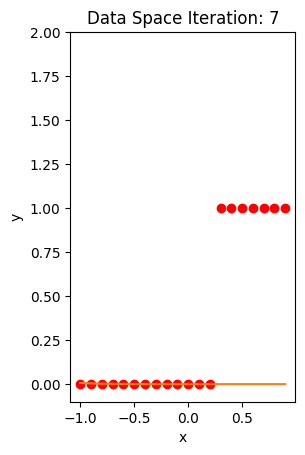

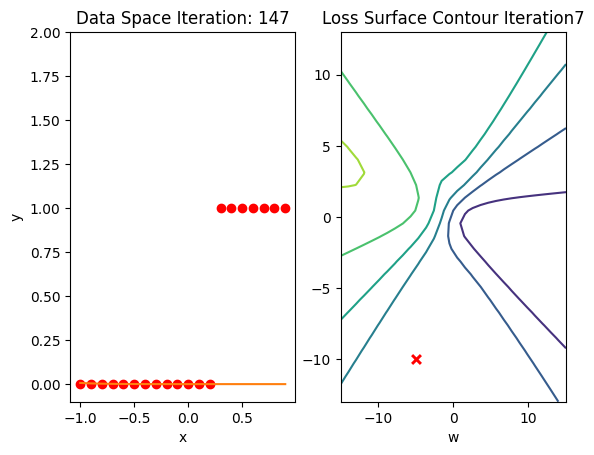

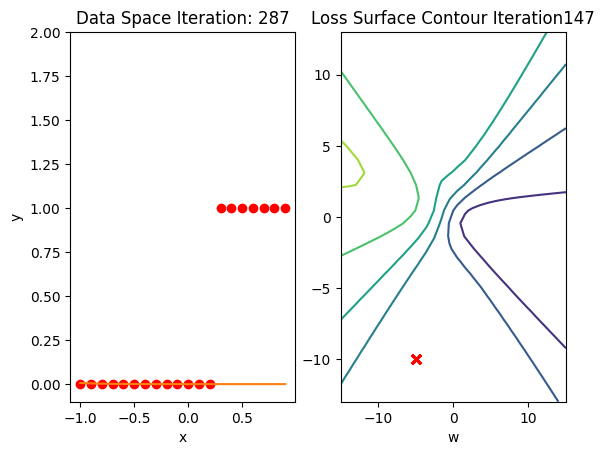

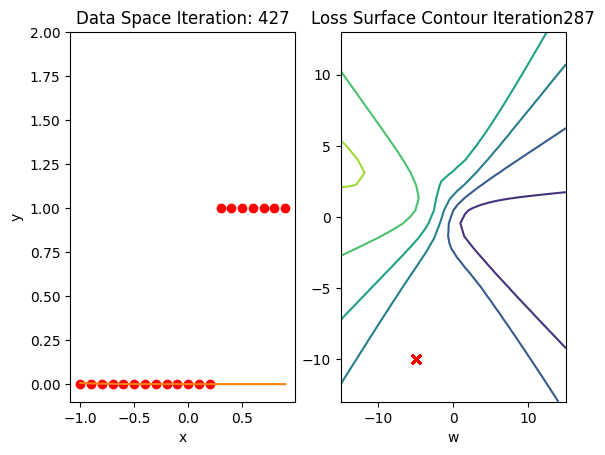

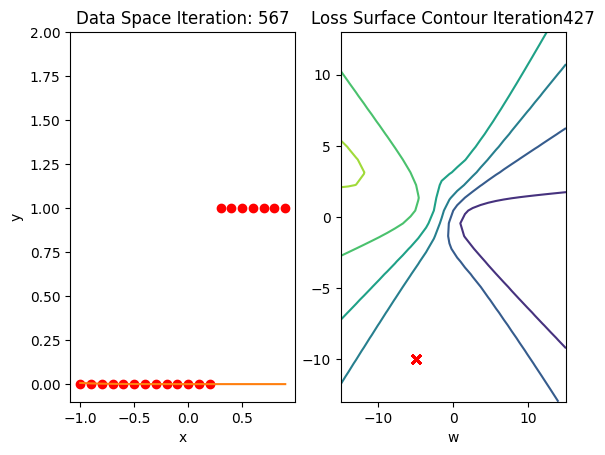

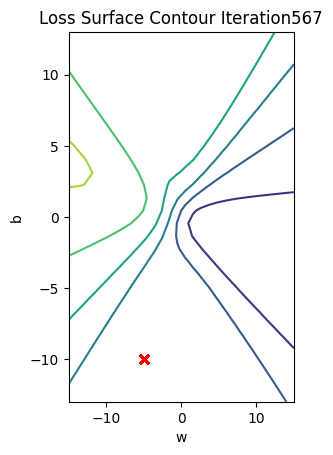

In [12]:
def train_model(num_epochs): 
    for epoch in range(num_epochs):
        for x, y in train_loader: 
            y_hat = model(x) 
            loss = criterion(y_hat, y) 
            optimizer.zero_grad() 
            get_surface.set_para_loss(model, loss.tolist()) 
        if epoch % 20 == 0: 
            get_surface.plot_ps()
train_model(100)

In [13]:
yhat = model(data_set.x)
label = yhat > 0.5
print("The accuracy: ", torch.mean((label == data_set.y.type(torch.ByteTensor)).type(torch.float)))

The accuracy:  tensor(0.6500)


In [14]:
def criterion_cross_entropy(yhat,y):
    out = -1 * torch.mean(y * torch.log(yhat) + (1 - y) * torch.log(1 - yhat))
    return out

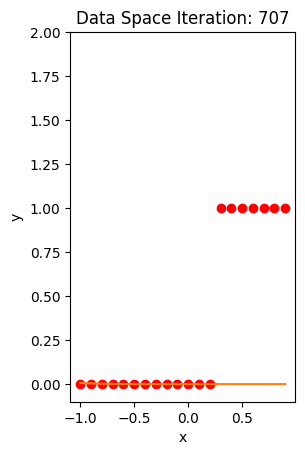

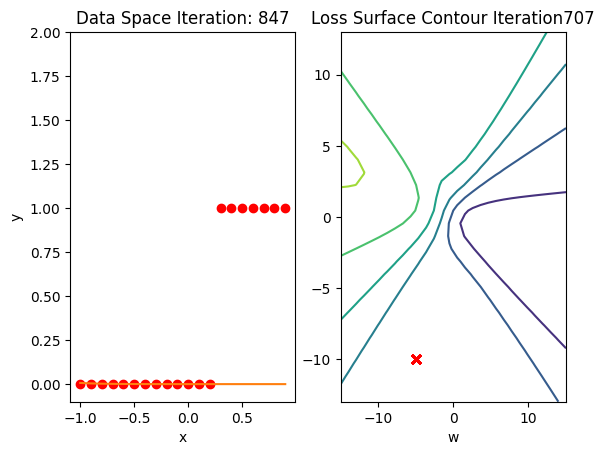

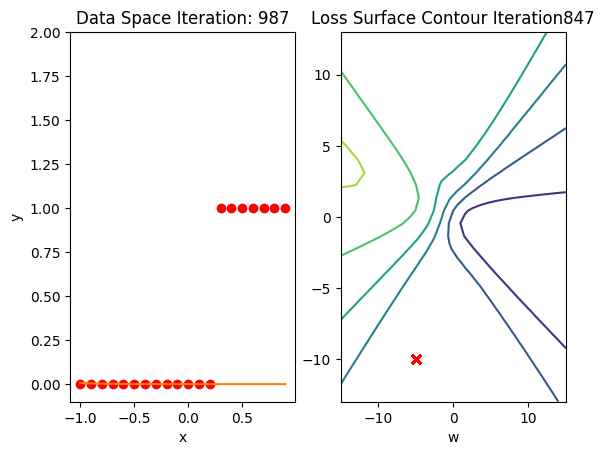

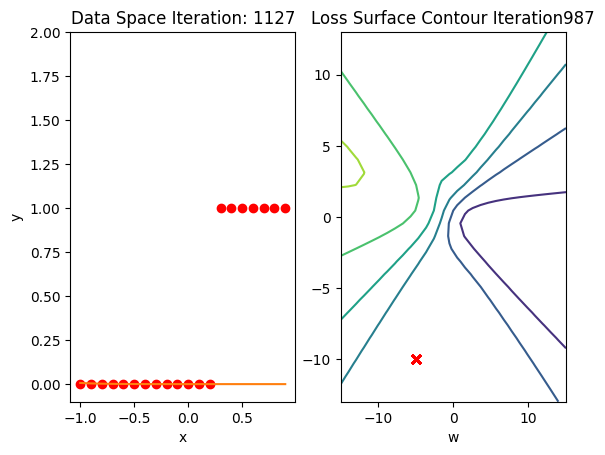

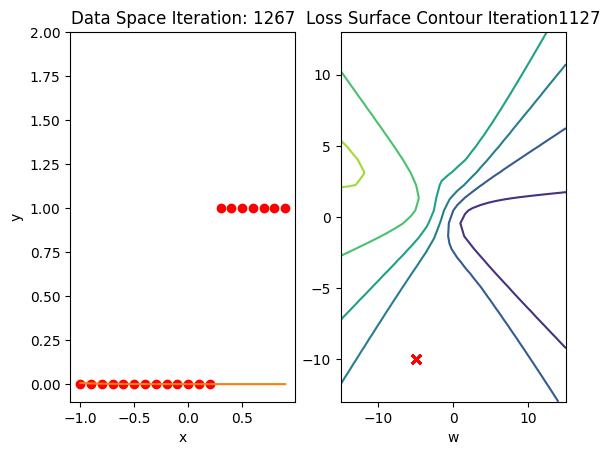

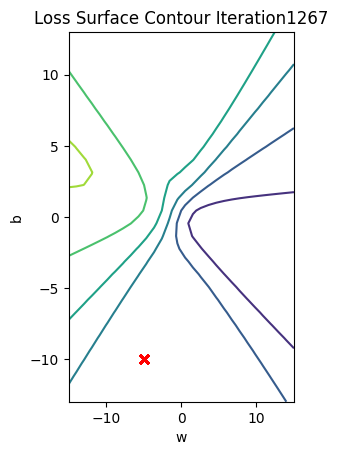

In [15]:
def train_model(epochs):
    for epoch in range(epochs):
        for x, y in train_loader:
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            get_surface.set_para_loss(model, loss.tolist())
        if epoch % 20 == 0:
            get_surface.plot_ps()
            
train_model(100)

In [16]:
yhat = model(data_set.x)
label = yhat > 0.5
print("The accuracy: ", torch.mean((label == data_set.y.type(torch.ByteTensor)).type(torch.float)))

The accuracy:  tensor(0.6500)
